In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import decimal
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.12.0
keras version 2.12.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Fri Jun  2 05:45:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W /  70W |    389MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0], 
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history):
  for metric in ["loss","val_loss","accuracy","val_accuracy"]:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)
  
  return model_train_history

def evaluate_save_model(model,test_data, model_train_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
  
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

In [ ]:
base_path = "/content/drive/MyDrive/cs152datasets/"
label_names = ["cats", "cats with clothes"]

from pathlib import Path
import imghdr
import os

# def valid_image(path):
#   try:
#     image = tf.io.read_file(path)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, [224, 224])
#     return True
#   except Exception as e:
#     print(e)
#     return False

# for label in label_names:
#   data_dir = base_path + "/" + label
#   image_extensions = [".png", ".jpg"]  # add there all your images file extensions

#   print(len(os.listdir(os.path.join(base_path, label))))

#   img_type_accepted_by_tf = ["jpeg", "png"]
#   for filepath in Path(data_dir).rglob("*"):
#       if filepath.suffix.lower() in image_extensions:
#           img_type = imghdr.what(filepath)
#           if img_type is None:
#               print(f"{filepath} is not an image")
#               os.remove(filepath)
#           elif img_type not in img_type_accepted_by_tf:
#               print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
#               os.remove(filepath)
#           elif not valid_image(str(filepath)):
#               print(f"{filepath} is not a valid image")
#               os.remove(filepath) 

# Number of unique labels
num_classes = len(label_names) 

# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

min_num_labels = min([len(os.listdir(os.path.join(base_path, label))) for label in label_names])

# Generate a list of labels and path to images
data_list = []
for label in label_names:
  # Images
  image_files = os.listdir(os.path.join(base_path, label))[:min_num_labels]
  data_list.extend([(label,os.path.join(base_path, label, f)) for f in image_files])
  print(f"Label '{label}' has {len(image_files)} images")

# more_kitten_files = os.listdir(os.path.join("/content/drive/MyDrive/cs152datasets/flickr/", "kitten"))[:500]
# data_list.extend([("kittens" , os.path.join("/content/drive/MyDrive/cs152datasets/flickr/", "kitten", f)) for f in more_kitten_files])

print("Full size of the dataset:", len(data_list))
print("data_list:", data_list[:5])

Label 'cats' has 435 images
Label 'cats with clothes' has 435 images
Full size of the dataset: 870
data_list: [('cats', '/content/drive/MyDrive/cs152datasets/cats/00000005_001.jpg'), ('cats', '/content/drive/MyDrive/cs152datasets/cats/00000004_023.jpg'), ('cats', '/content/drive/MyDrive/cs152datasets/cats/00000006_016.jpg'), ('cats', '/content/drive/MyDrive/cs152datasets/cats/00000007_015.jpg'), ('cats', '/content/drive/MyDrive/cs152datasets/cats/00000011_010.jpg')]


/content/drive/MyDrive/cs152datasets/cats with clothes/33.jpg
/content/drive/MyDrive/cs152datasets/cats/00000415_021.jpg
/content/drive/MyDrive/cs152datasets/cats/00000372_019.jpg
/content/drive/MyDrive/cs152datasets/cats/00000322_010.jpg
/content/drive/MyDrive/cs152datasets/cats with clothes/360.jpg
/content/drive/MyDrive/cs152datasets/cats/00000432_006.jpg
/content/drive/MyDrive/cs152datasets/cats with clothes/27.jpg
/content/drive/MyDrive/cs152datasets/cats with clothes/602.jpg
/content/drive/MyDrive/cs152datasets/cats with clothes/242.jpg
/content/drive/MyDrive/cs152datasets/cats with clothes/387.jpg
/content/drive/MyDrive/cs152datasets/cats/00000365_017.jpg
/content/drive/MyDrive/cs152datasets/cats with clothes/287.jpg


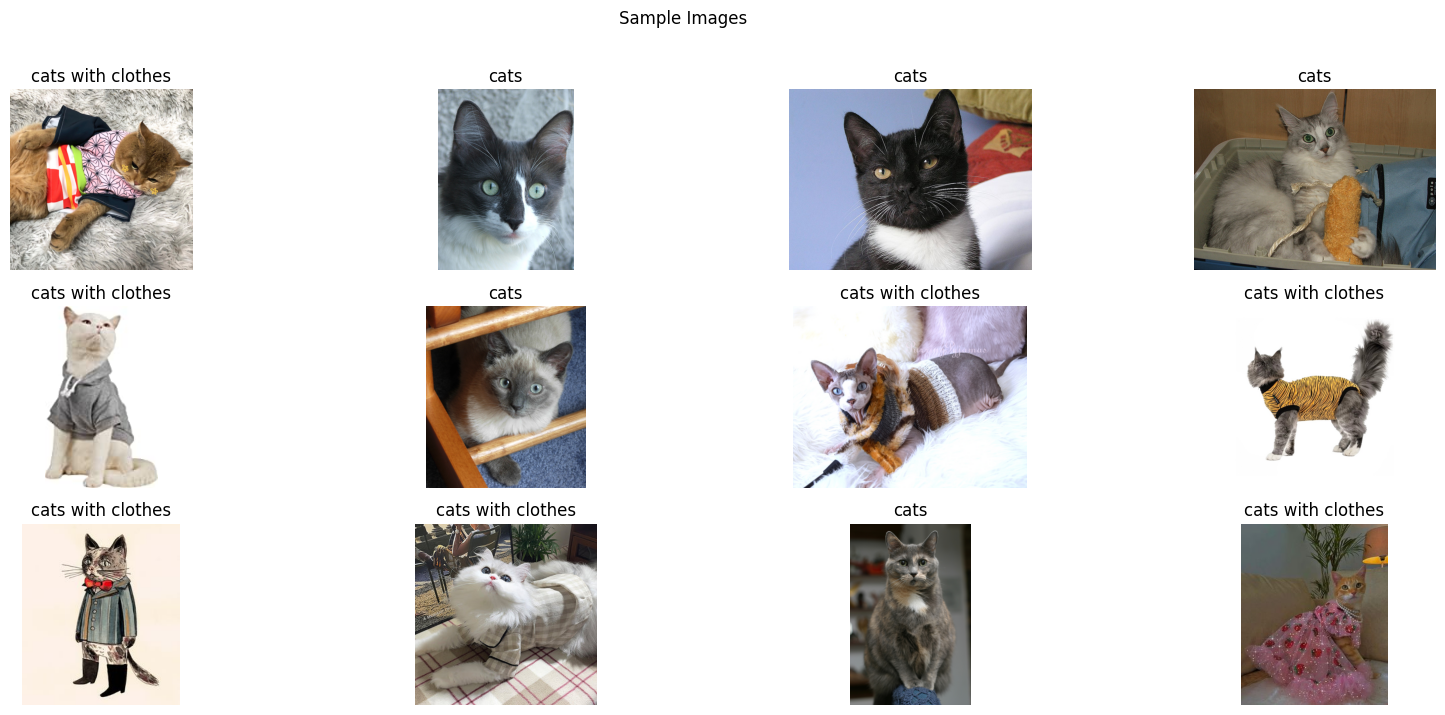

In [ ]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    print(data_list[img_idx][1])
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

In [ ]:
# Build data x, y
data_x = [itm[1] for itm in data_list]
data_y = [itm[0] for itm in data_list]

print("data_x:", len(data_x))
print("data_y:", len(data_y))
print("data_x:", data_x[:5])
print("data_y:", data_y[:5])

data_x: 870
data_y: 870
data_x: ['/content/drive/MyDrive/cs152datasets/cats/00000005_001.jpg', '/content/drive/MyDrive/cs152datasets/cats/00000004_023.jpg', '/content/drive/MyDrive/cs152datasets/cats/00000006_016.jpg', '/content/drive/MyDrive/cs152datasets/cats/00000007_015.jpg', '/content/drive/MyDrive/cs152datasets/cats/00000011_010.jpg']
data_y: ['cats', 'cats', 'cats', 'cats', 'cats']


In [ ]:
test_percent = 0.10
validation_percent = 0.2

# Split data into train / test
train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x, data_y, test_size=test_percent, stratify=data_y)

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=test_percent, stratify=train_validate_y)

print("train_x count:", len(train_x))
print("validate_x count:", len(validate_x))
print("test_x count:", len(test_x))

train_x count: 704
validate_x count: 79
test_x count: 87


In [ ]:
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32

train_shuffle_buffer_size = len(train_x)
validation_shuffle_buffer_size = len(validate_x)

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = keras.applications.mobilenet_v2.preprocess_input(image)
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]
test_processed_y = [label2index[label] for label in test_y]

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

############
# Test data
############
# Apply all data processing logic
test_data = test_data.map(load_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(normalize, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(AUTOTUNE)

print("train_data", train_data)
print("validation_data", validation_data)
print("test_data", test_data)

train_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
validation_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
test_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# Create an experiment
create_experiment()

In [ ]:
# Build Model
def build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = False):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Load a pretrained model from keras.applications
  tranfer_model_base = keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

  # Freeze the mobileNet model layers
  tranfer_model_base.trainable = train_base

  model = Sequential([
        keras.Input(shape=input_shape),
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(0.2),
        tranfer_model_base,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
  ], name='mobilenetv2_train_base_' + str(train_base))

  return model, tranfer_model_base

Model: "mobilenetv2_train_base_False"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                      

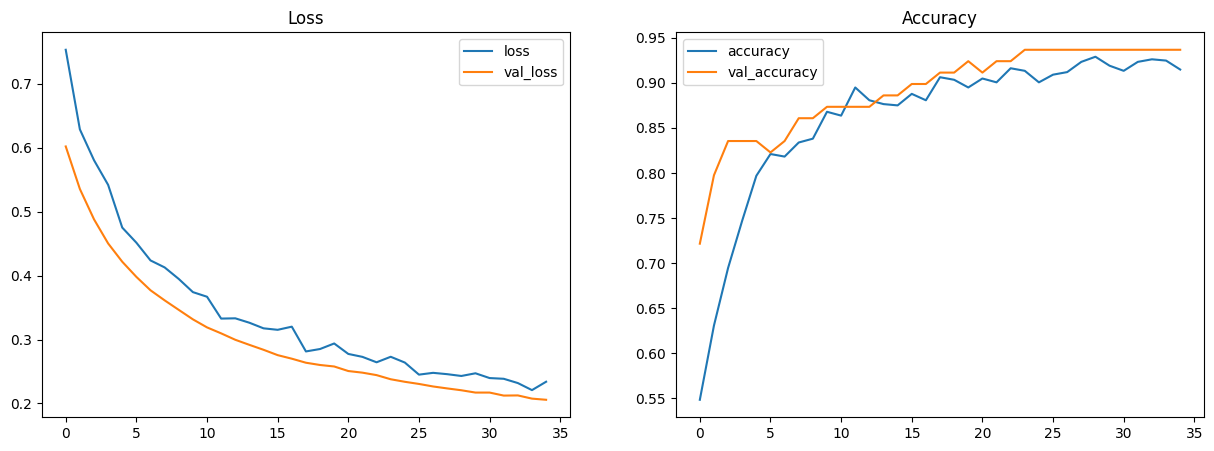

3/3 [==============================] - 1s 401ms/step - loss: 0.1985 - accuracy: 0.9310
[0.19846270978450775, 0.931034505367279]


In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
initial_epoch = 0
epochs = 35

# Free up memory
K.clear_session()

loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

# Build the model
model, base_model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = False)

# Print the model architecture
print(model.summary())

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

1/1 [==============================] - 3s 3s/step
[0.99195224 0.76881075 0.04047305 0.01587609 0.9625329  0.772852
 0.6911006  0.03981506 0.9670009  0.98554695 0.13394408 0.12451635]
predictions.shape: (12,)


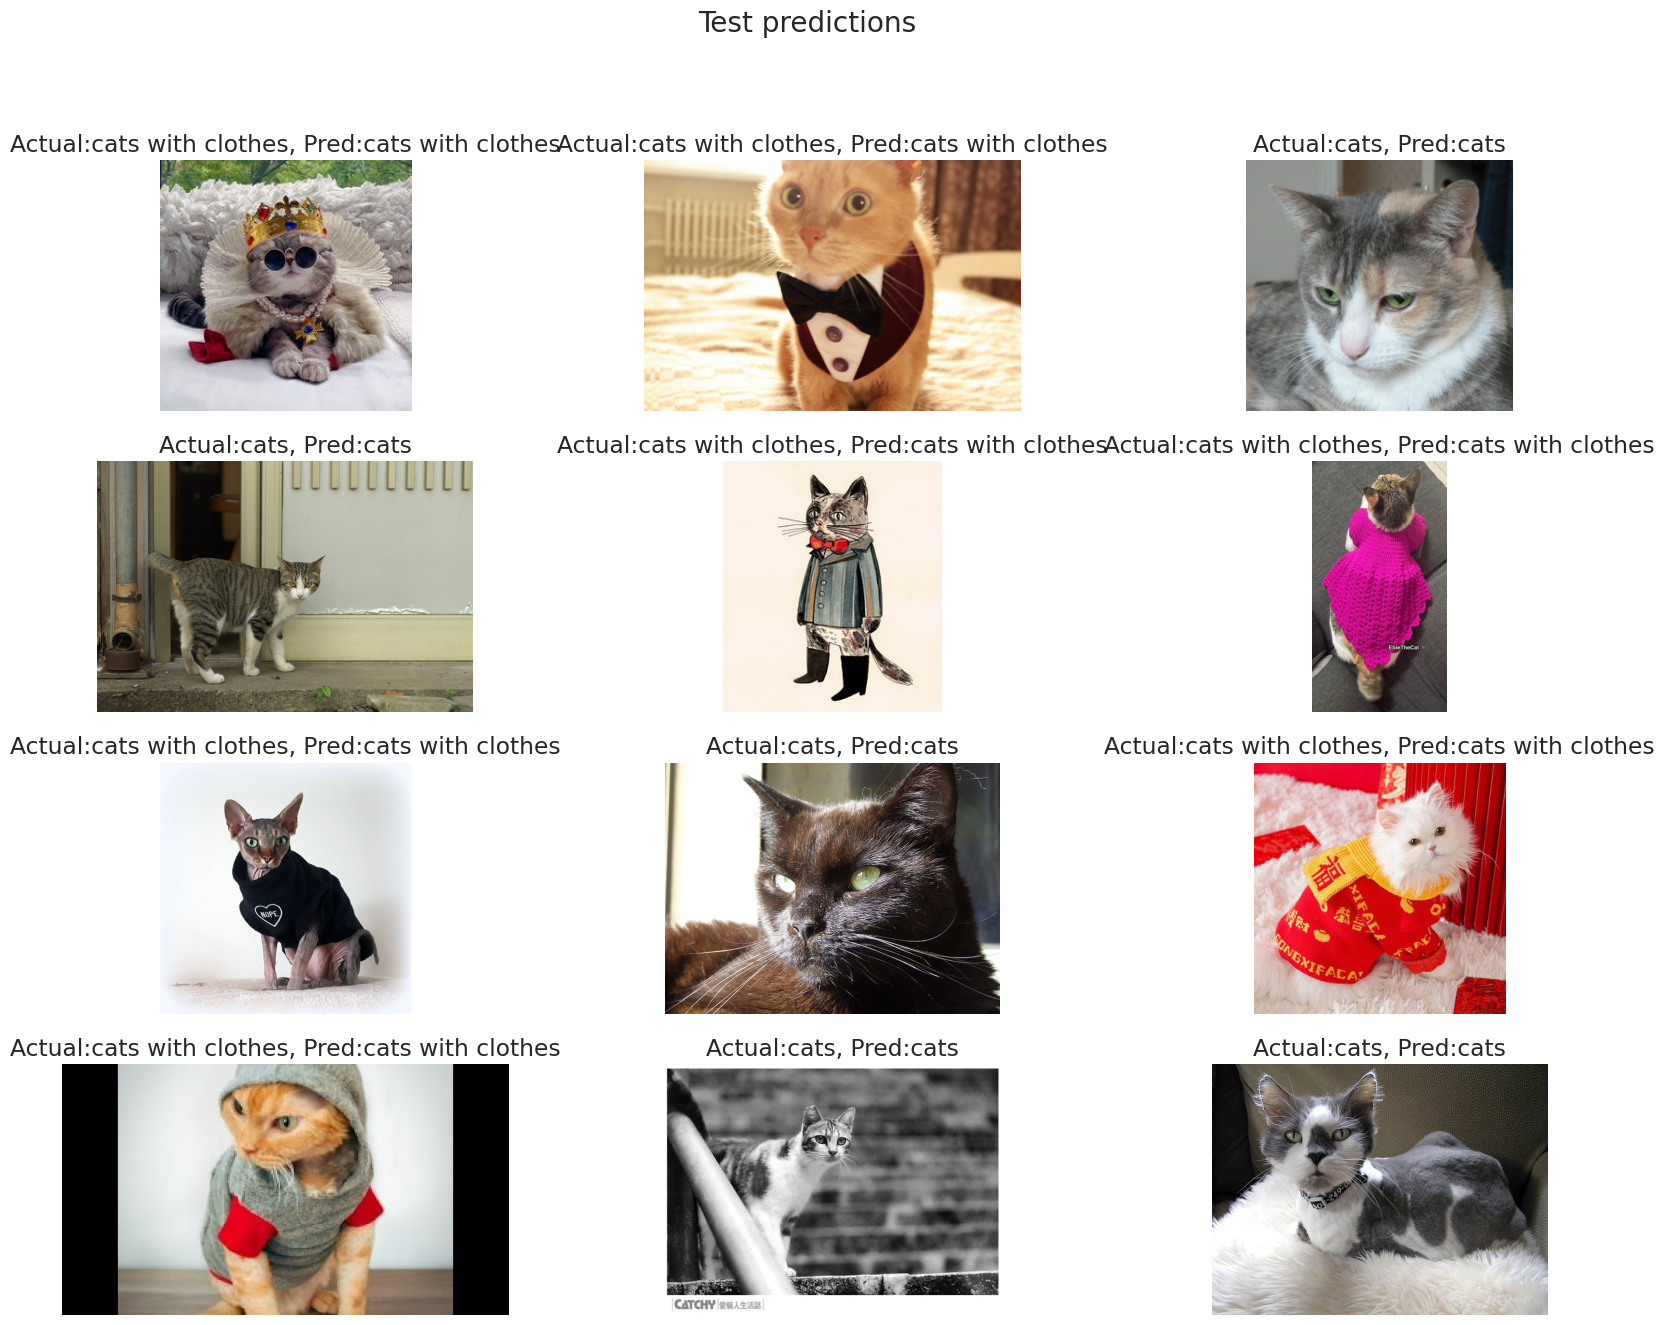

In [ ]:
# Generate a random sample of index
import random

image_samples = random.sample(range(len(test_x)), 12)
image_width = 224
image_height = 224
num_channels = 3

# Prepare the data
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height, image_width])

  image = keras.applications.mobilenet.preprocess_input(image)

  return image

prediction_image_paths = [test_x[img_idx] for img_idx in image_samples]

# Prepare the data for prediction
prediction_data = tf.data.Dataset.from_tensor_slices((prediction_image_paths))
prediction_data = prediction_data.map(preprocess_image, num_parallel_calls=AUTOTUNE)
prediction_data = prediction_data.batch(len(prediction_image_paths))

# Make prediction
predictions = model.predict(prediction_data).flatten()
print(predictions)
print("predictions.shape:", predictions.shape)


fig = plt.figure(figsize=(20,15))
for i, img_idx in enumerate(image_samples):
    axs = fig.add_subplot(4, 3, i+1)
    
    # Read image
    image = cv2.imread(test_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    
    # Actual label vs prediction
    prediction_label = index2label[predictions[i] > 0.5]
    axs.set_title("Actual:" + test_y[img_idx] + ", Pred:" + prediction_label)

    plt.axis('off')

plt.suptitle("Test predictions")
plt.show()

1/1 [==============================] - 1s 777ms/step


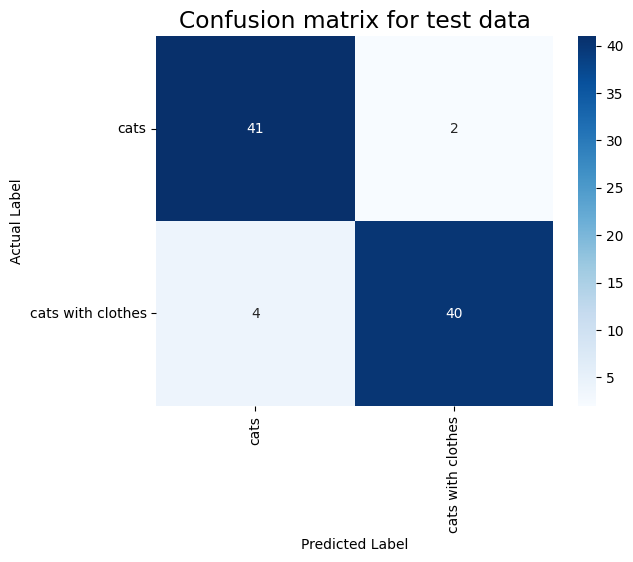

In [ ]:
def get_actual_predicted_labels(dataset): 
  predicted_classes = np.array([])
  true_classes =  np.array([])

  for x, y in dataset:
    predicted_classes = np.concatenate([predicted_classes, (model.predict(x) > 0.5).flatten()])
    true_classes = np.concatenate([true_classes, y.numpy().flatten()])

  return true_classes, predicted_classes

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title(f'Confusion matrix for {ds_type} data')
  ax.set_xlabel('Predicted Label')
  ax.set_ylabel('Actual Label')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

actual, predicted = get_actual_predicted_labels(test_data)
plot_confusion_matrix(actual, predicted, label_names, 'test')

In [ ]:
############################
# Fine Tuning Training Params
############################
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

loss = keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10)

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

fine_tune_epochs = 7

total_epochs = epochs + fine_tune_epochs

start_time = time.time()
history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=training_results.epoch[-1],
                         validation_data=validation_data,
                         verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)", execution_time)

acc = training_results.history['accuracy'] + history_fine.history['accuracy']
val_acc = training_results.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = training_results.history['loss'] + history_fine.history['loss']
val_loss = training_results.history['val_loss'] + history_fine.history['val_loss']

evaluate_save_model(model, test_data, history_fine.history, execution_time, learning_rate / 10, batch_size, fine_tune_epochs, optimizer, save=True)

Number of layers in the base model:  154
Model: "mobilenetv2_train_base_False"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0       

KeyboardInterrupt: ignored

In [ ]:
def get_actual_predicted_labels(dataset): 
  predicted_classes = np.array([])
  true_classes =  np.array([])

  for x, y in dataset:
    predicted_classes = np.concatenate([predicted_classes, (model.predict(x) > 0.5).flatten()])
    true_classes = np.concatenate([true_classes, y.numpy().flatten()])

  return true_classes, predicted_classes

def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title(f'Confusion matrix for {ds_type} data')
  ax.set_xlabel('Predicted Label')
  ax.set_ylabel('Actual Label')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

actual, predicted = get_actual_predicted_labels(test_data)
plot_confusion_matrix(actual, predicted, label_names, 'test')

In [ ]:
# Generate a random sample of index
import random

image_samples = random.sample(range(len(test_x)), 12)
image_width = 224
image_height = 224
num_channels = 3

# Prepare the data
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height, image_width])

  image = keras.applications.mobilenet.preprocess_input(image)

  return image

prediction_image_paths = [test_x[img_idx] for img_idx in image_samples]

# Prepare the data for prediction
prediction_data = tf.data.Dataset.from_tensor_slices((prediction_image_paths))
prediction_data = prediction_data.map(preprocess_image, num_parallel_calls=AUTOTUNE)
prediction_data = prediction_data.batch(len(prediction_image_paths))

# Make prediction
predictions = model.predict(prediction_data).flatten()
print(predictions)
print("predictions.shape:", predictions.shape)


fig = plt.figure(figsize=(20,15))
for i, img_idx in enumerate(image_samples):
    axs = fig.add_subplot(4, 3, i+1)
    
    # Read image
    image = cv2.imread(test_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    
    # Actual label vs prediction
    prediction_label = index2label[predictions[i] > 0.5]
    axs.set_title("Actual:" + test_y[img_idx] + ", Pred:" + prediction_label)

    plt.axis('off')

plt.suptitle("Test predictions")
plt.show()